# Parse data structure into a pandas DataFrame
Parse data paths from the Smart-Kages folder structure and store them in a pandas DataFrames.

Also, load time adjustments to help estimate start and end times for each 1-hour segment.

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sleap_io as sio
from tqdm import tqdm

from smart_kages_movement.datetime import (
    extract_datetimes,
    extract_frame_timestamps,
    find_segment_overlaps,
)
from smart_kages_movement.io import (
    get_video_shape,
    parse_data_into_df,
    save_segment_timestamps,
)
from smart_kages_movement.plots import show_first_frame_corner

## Configuration
Define some global variables and paths.

In [2]:
# Path to the data directory containing all kages.
# data_dir = Path.home() / "Data" / "Smart-Kages"
data_dir = Path("/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB")
assert data_dir.exists(), f"Data directory {data_dir} does not exist."

# Path for saving the processed data (in this case, a subfolder of 'data_dir').
save_dir = data_dir / "movement_analysis"
save_dir.mkdir(parents=True, exist_ok=True)

## Aggregate segment paths into a single dataframe

The data is stored per Smart-Kage, in folders names as `kageN`, e.g. `kage1`, `kage2`, etc.

Each Smart-Kage folder contains:
- daily videos are stored in `videos/YYYY/MM/DD/`, split into 1-hour segments. Each 1-hour segment is an `.mp4` file named `kageN_YYYYMMDD_HHMMSS.mp4`.
- corresponding DeepLabCut (DLC) predictions are stored in `analysis/dlc_output/YYYY/MM/DD/`. Each 1-hour `.h5` file therein is prefixed with `kageN_YYYYMMDD_HHMMSS`.

Let's parse the relevant parts of the data structure into a single dataframe.

In [3]:
df = parse_data_into_df(data_dir)
df.head()

Found 33 kage directories:  kage1 kage10 kage11 kage12 kage13 kage14 kage15 kage16 kage17 kage18 kage19 kage2 kage20 kage21 kage22 kage23 kage24 kage25 kage26 kage27 kage28 kage29 kage3 kage30 kage31 kage32 kage33 kage4 kage5 kage6 kage7 kage8 kage9
Found a total of 24873 .h5 pose files output by DLC.


start_datetime  \
kage  date     hour                       
kage1 20240403 09   2024-04-03 09:54:20   
               10   2024-04-03 10:00:02   
               11   2024-04-03 11:01:03   
               12   2024-04-03 12:01:04   
               13   2024-04-03 13:01:03   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               10    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               12    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               13    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   

                                                       video_file_path  
kage  date     hour                                                     
kage1 20240403 09    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               10    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               12    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               13    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...

## Add some video metadata
We reach each video's `n_frames`, `height`, `width`, and `n_channels` from the video file itself, using `sleap-io`.

These metadata are added as columns to the dataframe.

In [4]:
video_paths = df["video_file_path"].tolist()

# Get video shapes with parallel processing
video_shapes = [None] * len(video_paths)
with ProcessPoolExecutor() as ex:
    futures = {ex.submit(get_video_shape, p): i for i, p in enumerate(video_paths)}
    for fut in tqdm(as_completed(futures), total=len(futures)):
        i = futures[fut]
        video_shapes[i] = fut.result()

# Store video shapes in the dataframe
video_shapes_df = pd.DataFrame(
    video_shapes,
    index=df.index,
    columns=["n_frames", "height", "width", "n_channels"],
)
df = pd.concat([df, video_shapes_df], axis=1)

100%|██████████| 24873/24873 [00:40<00:00, 614.15it/s]


Let's see if there are any videos where `n_channels` is not 3, which would indicate a non-RGB video.

In [8]:
df_non_rgb = df.copy()[df["n_channels"] != 3]
print(f"Found {len(df_non_rgb)} non-RGB videos.")
df_non_rgb.head(len(df_non_rgb))

Found 11 non-RGB videos.


start_datetime  \
kage   date     hour                       
kage1  20240403 11   2024-04-03 11:01:03   
       20240404 04   2024-04-04 04:01:04   
                06   2024-04-04 06:01:03   
kage18 20240403 11   2024-04-03 11:15:38   
kage21 20240415 06   2024-04-15 06:00:02   
       20240507 03   2024-05-07 03:00:01   
kage28 20240418 11   2024-04-18 11:00:32   
kage3  20240411 02   2024-04-11 02:00:02   
       20240415 14   2024-04-15 14:00:57   
       20240418 18   2024-04-18 18:01:03   
       20240501 15   2024-05-01 15:04:45   

                                                         pose_file_path  \
kage   date     hour                                                      
kage1  20240403 11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240404 04    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
                06    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
kage18 20240403 11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
kage21 20240415 06    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240507 03    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
kage28 20240418 11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
kage3  20240411 02    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240415 14    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240418 18    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240501 15    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   

                                                        video_file_path  \
kage   date     hour                                                      
kage1  20240403 11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240404 04    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
                06    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
kage18 20240403 11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
kage21 20240415 06    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240507 03    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
kage28 20240418 11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
kage3  20240411 02    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240415 14    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240418 18    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
       20240501 15    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   

                      n_frames  height  width  n_channels  
kage   date     hour                                       
kage1  20240403 11        7064     376    500           1  
       20240404 04        7023     376    500           1  
                06        7019     376    500           1  
kage18 20240403 11        5303     376    500           1  
kage21 20240415 06        7158     376    500           1  
       20240507 03        7141     376    500           1  
kage28 20240418 11        7111     376    500           1  
kage3  20240411 02        7163     376    500           1  
       20240415 14        7066     376    500           1  
       20240418 18        7046     376    500           1  
       20240501 15        6613     376    500           1

## Adjust datetimes for each segment
Above, we derived the start datetime of each video from its filename.
However, this is usually not the exact time when the video started recording.

We can find the exact start time for each video, as well as the exact timestamps for each frame, by inspecting two sources:

1. The `adjustments.txt` file. There is one per day, stored in `kageN/videos/YYYY/MM/DD/`, and contains one row per video file, formatted as `video_file:H,M,S`. For example, this could be `kage1_20240420_000002.mp4:0,0,6`. The hours, minutes, and seconds represent the offset relative to time `00:00:00` of that day. These values are extracted from the first video frame using computer vision. Negative, or otherwise impossible values indicate an error in this extraction process.

2. The `corrected_timestamps.pkl` file. There is one per day, stored in `kageN/analysis/dlc_output/YYYY/MM/DD/`. This file contains a dictionary mapping each pose filename to an array of corrected timestamps, expressed in seconds since the start of the hour. The first element should match the offset in the `adjustments.txt` file, and the rest should be derived by adding the frame timestamps (extracted from the .mp4 file) to this offset.

As a result of this process, the dataframe `df` will now have a `start_datetime` column with the exact start time of each video. Moreover, we will obtain a `frame_timestamps` dictionary, mapping each video segment, identified by a `(kage, date, hour)` tuple, to an array of timestamps expressed in seconds elapsed since the start of each video.

In [9]:
df, frame_timestamps = extract_datetimes(df)

/tmp/ipykernel_2998353/2965125456.py:1: UserWarning: First timestamp for kage1_20240420_070002DLC_resnet101_v2Jan17shuffle2_580000.h5 does not match the adjustment for kage1_20240420_070002.mp4. Setting start_datetime to NaT.
  df, frame_timestamps = extract_datetimes(df)
/tmp/ipykernel_2998353/2965125456.py:1: UserWarning: First timestamp for kage1_20240426_070002DLC_resnet101_v2Jan17shuffle2_580000.h5 does not match the adjustment for kage1_20240426_070002.mp4. Setting start_datetime to NaT.
  df, frame_timestamps = extract_datetimes(df)
/tmp/ipykernel_2998353/2965125456.py:1: UserWarning: First timestamp for kage1_20240427_070002DLC_resnet101_v2Jan17shuffle2_580000.h5 does not match the adjustment for kage1_20240427_070002.mp4. Setting start_datetime to NaT.
  df, frame_timestamps = extract_datetimes(df)
/tmp/ipykernel_2998353/2965125456.py:1: UserWarning: First timestamp for kage1_20240428_070002DLC_resnet101_v2Jan17shuffle2_580000.h5 does not match the adjustment for kage1_2024042

### Quality control 1: start datetime mismatches between `adjustments.txt` and `corrected_timestamps.pkl`
Some warnings may have appeared during the adjustment, flagging invalid adjustments values or mismatches between the `adjustments.txt` and the `corrected_timestamps.pkl`. We have marked all such problematic segments as having a `start_datetime` of `NaT` (Not a Time) in the dataframe.

In [10]:
invalid_datetimes = df[df["start_datetime"].isna()]
if not invalid_datetimes.empty:
    print(
        f"Found {len(invalid_datetimes)} videos with invalid adjustments",
        "or mismatches between the adjustment and corrected_timestamps.pkl.",
    )
else:
    print("All videos have valid start_datetimes.")

invalid_datetimes[["start_datetime"]]

Found 51 videos with invalid adjustments or mismatches between the adjustment and corrected_timestamps.pkl.


start_datetime
kage   date     hour               
kage1  20240420 07              NaT
       20240426 07              NaT
       20240427 07              NaT
       20240428 07              NaT
       20240429 07              NaT
       20240430 07              NaT
       20240502 07              NaT
       20240505 07              NaT
       20240507 07              NaT
kage10 20240508 16              NaT
kage11 20240404 20              NaT
kage16 20240507 15              NaT
kage17 20240405 20              NaT
       20240430 07              NaT
kage18 20240421 04              NaT
       20240424 07              NaT
       20240502 07              NaT
       20240505 07              NaT
kage2  20240403 14              NaT
       20240404 14              NaT
       20240405 20              NaT
       20240415 07              NaT
       20240418 07              NaT
       20240422 07              NaT
       20240423 07              NaT
       20240424 07              NaT
kage3  20240404 04              NaT
       20240422 07              NaT
       20240423 07              NaT
       20240425 07              NaT
       20240504 07              NaT
       20240506 07              NaT
kage4  20240411 07              NaT
       20240420 07              NaT
       20240508 15              NaT
kage5  20240406 04              NaT
       20240415 07              NaT
       20240421 00              NaT
       20240501 09              NaT
       20240504 07              NaT
kage6  20240407 09              NaT
       20240430 07              NaT
kage7  20240414 07              NaT
       20240423 07              NaT
       20240507 12              NaT
kage8  20240415 07              NaT
       20240420 07              NaT
       20240423 07              NaT
       20240425 07              NaT
       20240430 07              NaT
kage9  20240423 07              NaT

We can open the first frame of each problematic video and look at the timestamps burned into the top-left corner.

('kage1', '20240420', '07')


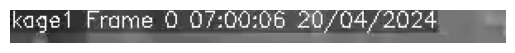

('kage1', '20240426', '07')


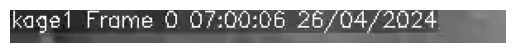

('kage1', '20240427', '07')


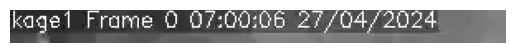

('kage1', '20240428', '07')


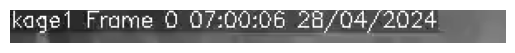

('kage1', '20240429', '07')


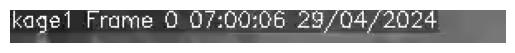

('kage1', '20240430', '07')


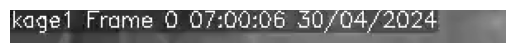

('kage1', '20240502', '07')


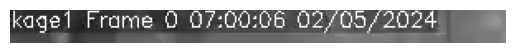

('kage1', '20240505', '07')


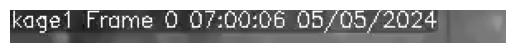

('kage1', '20240507', '07')


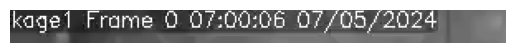

('kage10', '20240508', '16')


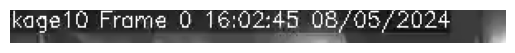

('kage11', '20240404', '20')


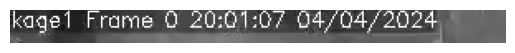

('kage16', '20240507', '15')


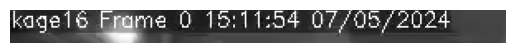

('kage17', '20240405', '20')


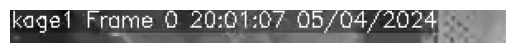

('kage17', '20240430', '07')


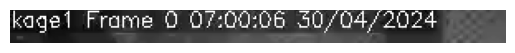

('kage18', '20240421', '04')


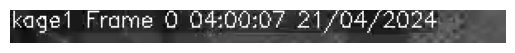

('kage18', '20240424', '07')


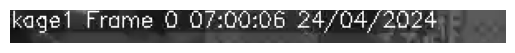

('kage18', '20240502', '07')


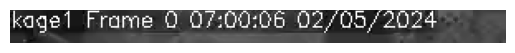

('kage18', '20240505', '07')


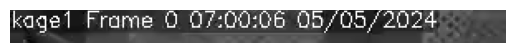

('kage2', '20240403', '14')


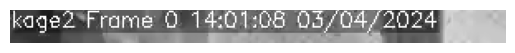

('kage2', '20240404', '14')


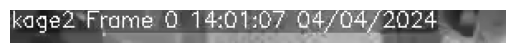

('kage2', '20240405', '20')


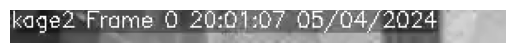

('kage2', '20240415', '07')


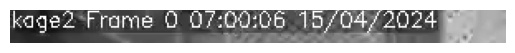

('kage2', '20240418', '07')


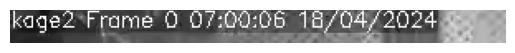

('kage2', '20240422', '07')


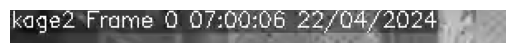

('kage2', '20240423', '07')


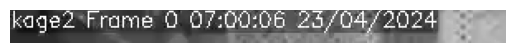

('kage2', '20240424', '07')


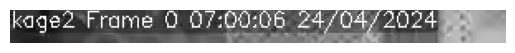

('kage3', '20240404', '04')


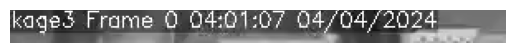

('kage3', '20240422', '07')


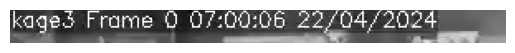

('kage3', '20240423', '07')


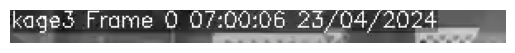

('kage3', '20240425', '07')


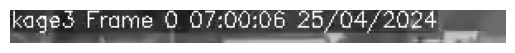

('kage3', '20240504', '07')


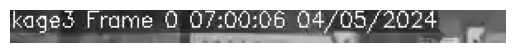

('kage3', '20240506', '07')


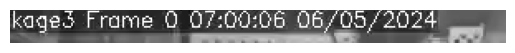

('kage4', '20240411', '07')


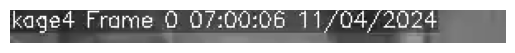

('kage4', '20240420', '07')


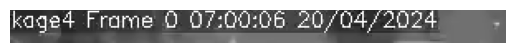

('kage4', '20240508', '15')


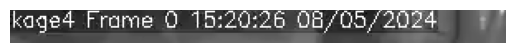

('kage5', '20240406', '04')


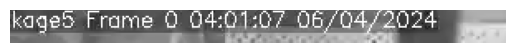

('kage5', '20240415', '07')


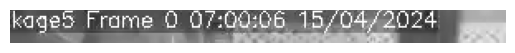

('kage5', '20240421', '00')


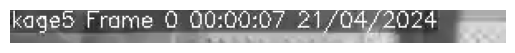

('kage5', '20240501', '09')


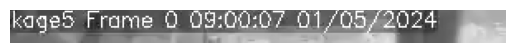

('kage5', '20240504', '07')


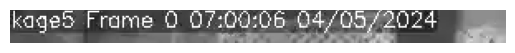

('kage6', '20240407', '09')


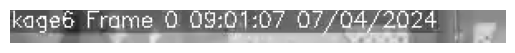

('kage6', '20240430', '07')


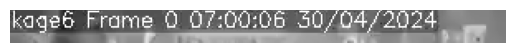

('kage7', '20240414', '07')


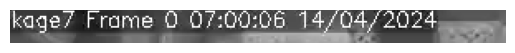

('kage7', '20240423', '07')


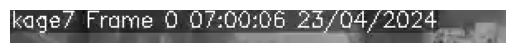

('kage7', '20240507', '12')


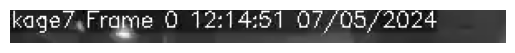

('kage8', '20240415', '07')


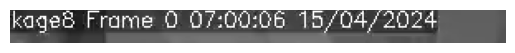

('kage8', '20240420', '07')


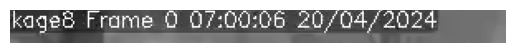

('kage8', '20240423', '07')


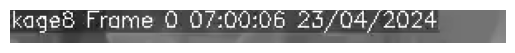

('kage8', '20240425', '07')


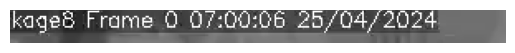

('kage8', '20240430', '07')


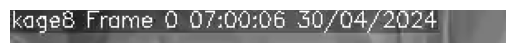

('kage9', '20240423', '07')


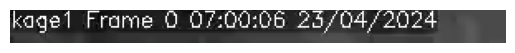

In [11]:
manual_start_datetimes = {}

for idx, row in invalid_datetimes.iterrows():
    print(idx)
    show_first_frame_corner(row["video_file_path"])

Below, we will manually enter the correct start datetimes for each problematic video,
as a dictionary mapping `(kage, date, hour)` tuples to datetimes in the format `YYYY-MM-DD HH:MM:SS`.
If there are no problematic videos, this dictionary can be empty.

In [12]:
manual_start_datetimes = {
    ("kage1", "20240420", "07"): "2024-04-20 07:00:06",
    ("kage1", "20240426", "07"): "2024-04-26 07:00:06",
    ("kage1", "20240427", "07"): "2024-04-27 07:00:06",
    ("kage1", "20240428", "07"): "2024-04-28 07:00:06",
    ("kage1", "20240429", "07"): "2024-04-29 07:00:06",
    ("kage1", "20240430", "07"): "2024-04-30 07:00:06",
    ("kage1", "20240502", "07"): "2024-05-02 07:00:06",
    ("kage1", "20240505", "07"): "2024-05-05 07:00:06",
    ("kage1", "20240507", "07"): "2024-05-07 07:00:06",
    ("kage10", "20240508", "16"): "2024-05-08 16:02:45",
    ("kage11", "20240404", "20"): "2024-04-04 20:01:07",
    ("kage16", "20240507", "15"): "2024-05-07 15:11:54",
    ("kage17", "20240405", "20"): "2024-04-05 20:01:07",
    ("kage17", "20240430", "07"): "2024-04-30 07:00:06",
    ("kage18", "20240421", "04"): "2024-04-21 04:00:07",
    ("kage18", "20240424", "07"): "2024-04-24 07:00:06",
    ("kage18", "20240502", "07"): "2024-05-02 07:00:06",
    ("kage18", "20240505", "07"): "2024-05-05 07:00:06",
    ("kage2", "20240403", "14"): "2024-04-03 14:01:08",
    ("kage2", "20240404", "14"): "2024-04-04 14:01:07",
    ("kage2", "20240405", "20"): "2024-04-05 20:01:07",
    ("kage2", "20240415", "07"): "2024-04-15 07:00:06",
    ("kage2", "20240418", "07"): "2024-04-18 07:00:06",
    ("kage2", "20240422", "07"): "2024-04-22 07:00:06",
    ("kage2", "20240423", "07"): "2024-04-23 07:00:06",
    ("kage2", "20240424", "07"): "2024-04-24 07:00:06",
    ("kage3", "20240404", "04"): "2024-04-04 04:01:07",
    ("kage3", "20240422", "07"): "2024-04-22 07:00:06",
    ("kage3", "20240423", "07"): "2024-04-23 07:00:06",
    ("kage3", "20240425", "07"): "2024-04-25 07:00:06",
    ("kage3", "20240504", "07"): "2024-05-04 07:00:06",
    ("kage3", "20240506", "07"): "2024-05-06 07:00:06",
    ("kage4", "20240411", "07"): "2024-04-11 07:00:06",
    ("kage4", "20240420", "07"): "2024-04-20 07:00:06",
    ("kage4", "20240508", "15"): "2024-05-08 15:20:26",
    ("kage5", "20240406", "04"): "2024-04-06 04:01:07",
    ("kage5", "20240415", "07"): "2024-04-15 07:00:06",
    ("kage5", "20240421", "00"): "2024-04-21 00:00:07",
    ("kage5", "20240501", "09"): "2024-05-01 09:00:07",
    ("kage5", "20240504", "07"): "2024-05-04 07:00:06",
    ("kage6", "20240407", "09"): "2024-04-07 09:01:07",
    ("kage6", "20240430", "07"): "2024-04-30 07:00:06",
    ("kage7", "20240414", "07"): "2024-04-14 07:00:06",
    ("kage7", "20240423", "07"): "2024-04-23 07:00:06",
    ("kage7", "20240507", "12"): "2024-05-07 12:14:51",
    ("kage8", "20240415", "07"): "2024-04-15 07:00:06",
    ("kage8", "20240420", "07"): "2024-04-20 07:00:06",
    ("kage8", "20240423", "07"): "2024-04-23 07:00:06",
    ("kage8", "20240425", "07"): "2024-04-25 07:00:06",
    ("kage8", "20240430", "07"): "2024-04-30 07:00:06",
    ("kage9", "20240423", "07"): "2024-04-23 07:00:06",
}


for (kage, date, hour), start_datetime in manual_start_datetimes.items():
    df.loc[(kage, date, hour), "start_datetime"] = pd.to_datetime(
        start_datetime, format="%Y-%m-%d %H:%M:%S"
    )

# All start datetimes should now be valid.
assert df["start_datetime"].notna().all(), "Some start datetimes are still NaT"

Now we can derive the precise datetime timestamps for each frame by adding the 
known `start_datetime` to the frame timestamps (which are in seconds elapsed).

We can also derive the `end_datetime` for each video as the last timestamp.

We also derive a `timestamps_datetime` dictionary, mapping each video segment, identified by a `(kage, date, hour)` tuple, to an array of precise datetime objects for each frame.

In [13]:
df["end_datetime"] = df["start_datetime"].copy()
timestamps_datetime = {}
for (kage, date, hour), seconds_elapsed in tqdm(frame_timestamps.items()):
    start_datetime = df.loc[(kage, date, hour), "start_datetime"]
    timedelta = pd.to_timedelta(seconds_elapsed, unit="s")
    datetime_stamps = start_datetime + timedelta
    # Derive the end datetimes from the last timestamp of each video.
    df.loc[(kage, date, hour), "end_datetime"] = datetime_stamps[-1]
    timestamps_datetime[(kage, date, hour)] = datetime_stamps

# Reorder columns for readability
df = df[
    [
        "start_datetime",
        "end_datetime",
        "n_frames",
        "n_channels",
        "height",
        "width",
        "pose_file_path",
        "video_file_path",
    ]
]
df.head()

100%|██████████| 24873/24873 [00:36<00:00, 686.12it/s]


start_datetime                  end_datetime  \
kage  date     hour                                                     
kage1 20240403 09   2024-04-03 09:54:24 2024-04-03 09:59:59.495354911   
               10   2024-04-03 10:00:06 2024-04-03 10:59:59.506997932   
               11   2024-04-03 11:01:07 2024-04-03 11:59:59.505496638   
               12   2024-04-03 12:01:08 2024-04-03 12:59:59.510819259   
               13   2024-04-03 13:01:07 2024-04-03 13:59:59.509458847   

                     n_frames  n_channels  height  width  \
kage  date     hour                                        
kage1 20240403 09         665           3     376    500   
               10        7183           3     376    500   
               11        7064           1     376    500   
               12        7059           3     376    500   
               13        7058           3     376    500   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               10    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               12    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               13    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   

                                                       video_file_path  
kage  date     hour                                                     
kage1 20240403 09    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               10    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               12    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               13    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...

### Quality control 2: Number of frames mismatch between video and timestamps
Let's check if the number of frame timestamps in each segment matches the number of frames in the video.
If some video frames are missing timestamps, we will extract them anew from the video file and fill the gaps with linear interpolation, if needed.
If this process still results in a mismatch, we will raise an error. Finally, we will update the `frame_timestamps` and `timestamps_datetime` dictionaries as well as the `end_datetime` column in the dataframe with the new corrected timestamps.

In [14]:
for (kage, date, hour), seconds_elapsed in tqdm(frame_timestamps.items()):
    n_frames = df.loc[(kage, date, hour), "n_frames"]
    if len(seconds_elapsed) != n_frames:
        print(
            f"Mismatch for {kage} {date} {hour}: {len(seconds_elapsed)} "
            f"frame timestamps vs {n_frames} video frames."
        )

        # Let's extract frame timestamps directly from the video
        # and interpolate missing timestamps if needed.
        new_seconds_elapsed = extract_frame_timestamps(
            df.loc[(kage, date, hour), "video_file_path"],
            expected_n_frames=n_frames,
        )

        # Check if the new timestamps now match the expected number of frames.
        if len(new_seconds_elapsed) != n_frames:
            raise ValueError(
                f"New timestamps length {len(new_seconds_elapsed)} still "
                f"does not match expected {n_frames} frames."
            )

        # Update the timestamps with the new ones.
        frame_timestamps[(kage, date, hour)] = new_seconds_elapsed
        # Re-compute datetime stamps from the known start datetime.
        start_datetime = df.loc[(kage, date, hour), "start_datetime"]
        timedelta = pd.to_timedelta(new_seconds_elapsed, unit="s")
        datetime_stamps = start_datetime + timedelta
        # Re-derive the end datetimes from the last timestamp of each video.
        df.loc[(kage, date, hour), "end_datetime"] = datetime_stamps[-1]
        timestamps_datetime[(kage, date, hour)] = datetime_stamps

  0%|          | 0/24873 [00:00<?, ?it/s]

Mismatch for kage10 20240414 10: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage10/videos/2024/04/14/kage10_20240414_100002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
  4%|▍         | 983/24873 [00:01<00:39, 606.69it/s]

Mismatch for kage11 20240419 19: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage11/videos/2024/04/19/kage11_20240419_190002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
  8%|▊         | 1948/24873 [00:03<00:37, 614.39it/s]

Mismatch for kage11 20240426 00: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage11/videos/2024/04/26/kage11_20240426_000002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
  8%|▊         | 2097/24873 [00:04<00:59, 384.12it/s]

Mismatch for kage13 20240507 07: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage13/videos/2024/05/07/kage13_20240507_070002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 16%|█▌        | 4039/24873 [00:06<00:29, 713.71it/s]

Mismatch for kage14 20240428 21: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage14/videos/2024/04/28/kage14_20240428_210002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 18%|█▊        | 4569/24873 [00:07<00:35, 578.56it/s]

Mismatch for kage15 20240415 17: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage15/videos/2024/04/15/kage15_20240415_170002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 20%|█▉        | 4864/24873 [00:09<00:44, 446.75it/s]

Mismatch for kage17 20240421 16: 7187 frame timestamps vs 7188 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage17/videos/2024/04/21/kage17_20240421_160003.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7187]
  new_seconds_elapsed = extract_frame_timestamps(
 27%|██▋       | 6740/24873 [00:11<00:26, 688.17it/s]

Mismatch for kage17 20240504 14: 7180 frame timestamps vs 7181 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage17/videos/2024/05/04/kage17_20240504_140002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7180]
  new_seconds_elapsed = extract_frame_timestamps(
 28%|██▊       | 7050/24873 [00:12<00:33, 529.69it/s]

Mismatch for kage18 20240504 08: 7175 frame timestamps vs 7176 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage18/videos/2024/05/04/kage18_20240504_080002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7175]
  new_seconds_elapsed = extract_frame_timestamps(
 32%|███▏      | 7907/24873 [00:14<00:31, 537.67it/s]

Mismatch for kage2 20240420 18: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage2/videos/2024/04/20/kage2_20240420_180002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 37%|███▋      | 9125/24873 [00:15<00:25, 611.07it/s]

Mismatch for kage20 20240427 15: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage20/videos/2024/04/27/kage20_20240427_150002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 40%|███▉      | 9901/24873 [00:17<00:26, 574.29it/s]

Mismatch for kage21 20240414 12: 7156 frame timestamps vs 7157 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage21/videos/2024/04/14/kage21_20240414_120002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7156]
  new_seconds_elapsed = extract_frame_timestamps(
 41%|████      | 10250/24873 [00:18<00:31, 462.29it/s]

Mismatch for kage23 20240428 02: 7190 frame timestamps vs 7191 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage23/videos/2024/04/28/kage23_20240428_020001.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7190]
  new_seconds_elapsed = extract_frame_timestamps(
 47%|████▋     | 11777/24873 [00:20<00:21, 606.86it/s]

Mismatch for kage24 20240421 03: 7187 frame timestamps vs 7188 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage24/videos/2024/04/21/kage24_20240421_030002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7187]
  new_seconds_elapsed = extract_frame_timestamps(
 49%|████▉     | 12285/24873 [00:22<00:24, 524.35it/s]

Mismatch for kage25 20240422 23: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage25/videos/2024/04/22/kage25_20240422_230002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 52%|█████▏    | 13004/24873 [00:23<00:23, 503.60it/s]

Mismatch for kage25 20240509 02: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage25/videos/2024/05/09/kage25_20240509_020002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 54%|█████▍    | 13391/24873 [00:25<00:26, 426.34it/s]

Mismatch for kage29 20240411 20: 7183 frame timestamps vs 7184 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage29/videos/2024/04/11/kage29_20240411_200002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7183]
  new_seconds_elapsed = extract_frame_timestamps(
 61%|██████▏   | 15280/24873 [00:26<00:14, 660.44it/s]

Mismatch for kage29 20240502 05: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage29/videos/2024/05/02/kage29_20240502_050002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 63%|██████▎   | 15744/24873 [00:28<00:16, 551.48it/s]

Mismatch for kage30 20240413 05: 7171 frame timestamps vs 7172 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage30/videos/2024/04/13/kage30_20240413_050002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7171]
  new_seconds_elapsed = extract_frame_timestamps(
 68%|██████▊   | 16793/24873 [00:29<00:13, 586.57it/s]

Mismatch for kage32 20240428 11: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage32/videos/2024/04/28/kage32_20240428_110002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 75%|███████▍  | 18614/24873 [00:31<00:08, 755.20it/s]

Mismatch for kage4 20240415 04: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage4/videos/2024/04/15/kage4_20240415_040002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 80%|████████  | 20007/24873 [00:33<00:06, 794.33it/s]

Mismatch for kage6 20240503 01: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage6/videos/2024/05/03/kage6_20240503_010002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 89%|████████▉ | 22166/24873 [00:34<00:02, 955.97it/s]

Mismatch for kage6 20240509 13: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage6/videos/2024/05/09/kage6_20240509_130002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 90%|████████▉ | 22322/24873 [00:36<00:03, 689.97it/s]

Mismatch for kage7 20240409 04: 7187 frame timestamps vs 7188 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage7/videos/2024/04/09/kage7_20240409_040002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7187]
  new_seconds_elapsed = extract_frame_timestamps(
 90%|█████████ | 22490/24873 [00:38<00:04, 519.01it/s]

Mismatch for kage7 20240415 01: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage7/videos/2024/04/15/kage7_20240415_010002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 91%|█████████ | 22607/24873 [00:39<00:05, 390.62it/s]

Mismatch for kage7 20240507 22: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage7/videos/2024/05/07/kage7_20240507_220002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
 93%|█████████▎| 23152/24873 [00:41<00:04, 374.24it/s]

Mismatch for kage9 20240420 12: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2998353/3007894659.py:11: UserWarning: Video /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/kage9/videos/2024/04/20/kage9_20240420_120002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(
100%|██████████| 24873/24873 [00:42<00:00, 581.84it/s]


### Quality control 3: Overlapping segments
Let's find out if there are any overlapping segments based on their `start_datetime` and `end_datetime`.

In [15]:
overlaps = find_segment_overlaps(df)
overlaps

No overlapping segments found.


We suspect that overlaps might be due to incorrect adjustments for the videos mentioned in `segment_A`, i.e. the timestamps of the first frame being incorrectly read by the computer vision algorithm. We can confirm this and manually correct this, as we did above.

In [16]:
if not overlaps:
    print("No need for inspection, no overlaps found.")
    print("You can skip the next cell.")
else:
    for _, row in overlaps.iterrows():
        segment_A = row["segment_A"]
        video_path = df.loc[segment_A, "video_file_path"]
        video = sio.load_video(video_path)
        first_frame = video[0]  # Get the first frame
        # matplotlib show the first frame
        plt.imshow(first_frame[:20, :300])
        plt.axis("off")
        print(segment_A)
        plt.show()

No need for inspection, no overlaps found.
You can skip the next cell.


In [17]:
more_manual_start_datetimes = {
    # ("kage1", "20240426", "07"): "2024-04-26 07:00:06",
}

for (kage, date, hour), start_datetime in more_manual_start_datetimes.items():
    df.loc[(kage, date, hour), "start_datetime"] = pd.to_datetime(
        start_datetime, format="%Y-%m-%d %H:%M:%S"
    )
    start = pd.Timestamp(start_datetime)
    timedelta = pd.to_timedelta(frame_timestamps[(kage, date, hour)], unit="s")
    timestamps_datetime[(kage, date, hour)] = start + timedelta
    df.loc[(kage, date, hour), "end_datetime"] = timestamps_datetime[
        (kage, date, hour)
    ][-1]

In [18]:
df.head()

start_datetime                  end_datetime  \
kage  date     hour                                                     
kage1 20240403 09   2024-04-03 09:54:24 2024-04-03 09:59:59.495354911   
               10   2024-04-03 10:00:06 2024-04-03 10:59:59.506997932   
               11   2024-04-03 11:01:07 2024-04-03 11:59:59.505496638   
               12   2024-04-03 12:01:08 2024-04-03 12:59:59.510819259   
               13   2024-04-03 13:01:07 2024-04-03 13:59:59.509458847   

                     n_frames  n_channels  height  width  \
kage  date     hour                                        
kage1 20240403 09         665           3     376    500   
               10        7183           3     376    500   
               11        7064           1     376    500   
               12        7059           3     376    500   
               13        7058           3     376    500   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               10    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               12    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   
               13    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...   

                                                       video_file_path  
kage  date     hour                                                     
kage1 20240403 09    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               10    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               11    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               12    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...  
               13    /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB...

### Quality control 4: Some final sanity checks
Everything should be fine now, but let's run some sanity checks

In [19]:
# All start datetimes should now be valid.
assert df["start_datetime"].notna().all(), "Some start datetimes are still NaT"

# Now, there should be no more overlaps
overlaps = find_segment_overlaps(df)
assert overlaps is None, (
    "There are still overlapping segments after manual adjustments."
)

# For each kage, the start_datetime values should be monotonic increasing
for kage in df.index.get_level_values("kage").unique():
    kage_start_datetimes = df.loc[kage, "start_datetime"].values
    assert np.all(np.diff(kage_start_datetimes) >= pd.Timedelta(0)), (
        f"Start datetimes for kage {kage} are not monotonic increasing."
    )

# For each row, the end_datetime should be greater than the start_datetime
assert np.all(df["end_datetime"] > df["start_datetime"]), (
    "Some end datetimes are not greater than start datetimes."
)

No overlapping segments found.


## Save the timestamps to txt files
We save the datetime timestamps to .txt files, with one file per 1-hour video segment.

We also store the paths to these .txt files in the `df` dataframe, in a new column called `timestamps_file_path`.

In [2]:
# Set this to True for faster processing with multiple cores.
# Set to False if ProcessPoolExecutor is causing errors on your system.
USE_MULTIPROCESSING = True

In [ ]:
timestamps_dir = save_dir / "timestamps"
timestamps_dir.mkdir(parents=True, exist_ok=True)


timestamps_file_paths = {}
items = list(timestamps_datetime.items())

if USE_MULTIPROCESSING:
    with ProcessPoolExecutor() as ex:
        futures = {
            ex.submit(save_segment_timestamps, it[0], it[1], timestamps_dir): it[0]
            for it in items
        }
        for fut in tqdm(as_completed(futures), total=len(futures)):
            key, path = fut.result()
            timestamps_file_paths[key] = path
else:
    for it in tqdm(items, total=len(items)):
        key, path = save_segment_timestamps(it[0], it[1], timestamps_dir)
        timestamps_file_paths[key] = path

# Add timestamps file paths to the DataFrame in one go
paths_s = pd.Series(timestamps_file_paths, name="timestamps_file_path")
paths_s.index = pd.MultiIndex.from_tuples(paths_s.index, names=df.index.names)
df.loc[paths_s.index, "timestamps_file_path"] = paths_s.values

print(f"Timestamps saved to {timestamps_dir}.")

100%|██████████| 24873/24873 [00:51<00:00, 487.10it/s]


Timestamps saved to /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/movement_analysis/timestamps.


## Save the dataframes as CSV files
Finally, we save the `df` dataframe to a CSV file for later use.

In [21]:
df.to_csv(save_dir / "all_segments.csv")
print(f"Dataframe saved to {save_dir}.")

Dataframe saved to /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/DB/movement_analysis.
